# Microarray
A microarray is a laboratory tool used to detect the expression of genes from a sample at the same time.  

Microarrays have thousands of tiny spots in defined positions, with each spot containing a known DNA sequence or gene. The DNA molecules attached to each slide act as probes to detect gene expression.   

To perform a microarray, mRNA molecules are typically collected from two different groups. For example, one group is considered as reference, which includes healthy samples and another group is experimental samples collected from a disease individual such as cancer.   

The two mRNA samples are then converted into complementary DNA (cDNA) and each sample is labeled with a fluorescent probe of a different color. For instance, the experimental cDNA may be labeled with a red fluorescent dye, whereas the reference cDNA may be labeled with a green fluorescent dye. The two samples are mixed together and allowed to bind to the microarray slide. cDNA molecules bind to the DNA probes on the slides is called hybridization. After hybridization, the microarray is scanned to measure the expression of each gene printed into the slide. The red spots show that the number of experimental samples is higher than the reference sample. If the expression of a particular gene is lower in the experimental sample than in the reference sample, then the corresponding spot on the microarray appears green. Finally, if there is an equal expression in the two samples, then the spot appears yellow.   

The microarray output data is in the form of a matrix table, which is finally in three formats SOFT, MINiML and TXT saved. Raw data is provided as a supplementary file.

# Loading libraries

In [3]:
library(GEOquery)
library(limma)
library(umap)
library(pheatmap)
library(gplots)
library(ggplot2)
library(reshape2)
library(plyr)
library(repr)
library(gridExtra)
library(ggpubr)
library(Rtsne)
library(MASS)
library(FactoMineR)
library(factoextra)

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



# Loading the $GSE48558$ series
The `getGEO()` method from the `GEOquery` package is used in order to download the `GEO SOFT` format of the [$GSE48558$](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE48558) and then parse it to the `R` structure obtaining the `GSE Matrix` and the `GPL annotations`:

In [71]:
gset <- getGEO("GSE48558", GSEMatrix =TRUE, getGPL=T, destdir='../Data/' , AnnotGPL = TRUE)
gset <- gset[[1]]

Found 1 file(s)

GSE48558_series_matrix.txt.gz

Using locally cached version: ../Data//GSE48558_series_matrix.txt.gz



In [72]:
dim(gset)

Features  Samples 
   32321      170

# Selecting proper samples
The *source name* column in the $GSE48558$, stands for the source of the biological material of the sample[^1].
There are $11$ different sample srources in this data series, including:  
  
- AML cell line
- AML patient
- B ALL cell line
- B ALL patient
- B normal
- T ALL cell line
- T ALL patient
- T normal
- Granulocytes normal
- Monocytes normal
- CD34+ normal  
  
We will only select the `Leukemia` AML samples and those with the `normal` phenotype value. The selection and the grouping were done first in the `GEO2R` [analysis tool](https://www.ncbi.nlm.nih.gov/geo/geo2r/?acc=GSE48558) provided by *ncbi* website itself. A string will be generated, which can be used to select and group the samples in the `R`:

[^1]: https://www.ncbi.nlm.nih.gov/geo/info/qqtutorial.html

In [73]:
gsms <- paste0("0000000000000XXXXXXXXXXXXXXXXXXXXXXXXXXX1XXX1XXXXX",
               "XXXXXXXXXXXXXXXXXX2X3XXX1X1442X3XX33XX33X2X3X2X3X5",
               "XXX5XXX5XXXXXXXXXXXXXXXXXXXXXXXXXXXXX1111111003000",
               "22222223444413333333")
sml <- strsplit(gsms, split="")[[1]]
sel <- which(sml != "X")
sml <- sml[sel]
gset <- gset[ ,sel]

Samples are grouped according to the following rules:  
  
- All the `AML` samples are grouped together.
- `Normal` samples are grouped based on their `source_name` (B, T, granulocytes, monocytes, and CD34+).  
  
Each number in the provided string stands for a group, and the `X` character means the corresponding sample won't be selected.  
Next we will create a `factor` from these class numbers and add the `group` column to the `gset`.

In [74]:
gs <- factor(sml)
groups <- make.names(c("AML","Granulocytes","B Cells","T Cells","Monocytes","CD34"))
levels(gs) <- groups
gset$group <- gs

# Data Quality Control

## Normalization

### Log Transformation
A technique that we can perform to scale the data properly is the *log transformation*. Our data may contain huge feature values that are unevenly distributed. The easiest solution is to scale them down using the `log` operation.

But before that, we'll check if we need to perform the *log transformation* or not. For this purpose we will simply find the range of feature values to find out if they are already log-scaled or not:

In [75]:
ex <- exprs(gset) # Biobase.exprs() returns a matrix of expression values
print(c(min(ex), max(ex)))

[1]  1.611473 13.761536


According to this, min value is $1.6$ and max value is $13.76$, so they are logarithmic already and data is normalized.

### Plotting the *expression* matrix
We can also plot the data to check if any normalization process is needed. If samples vary in range and scale, it's imperative to perform the normalization:

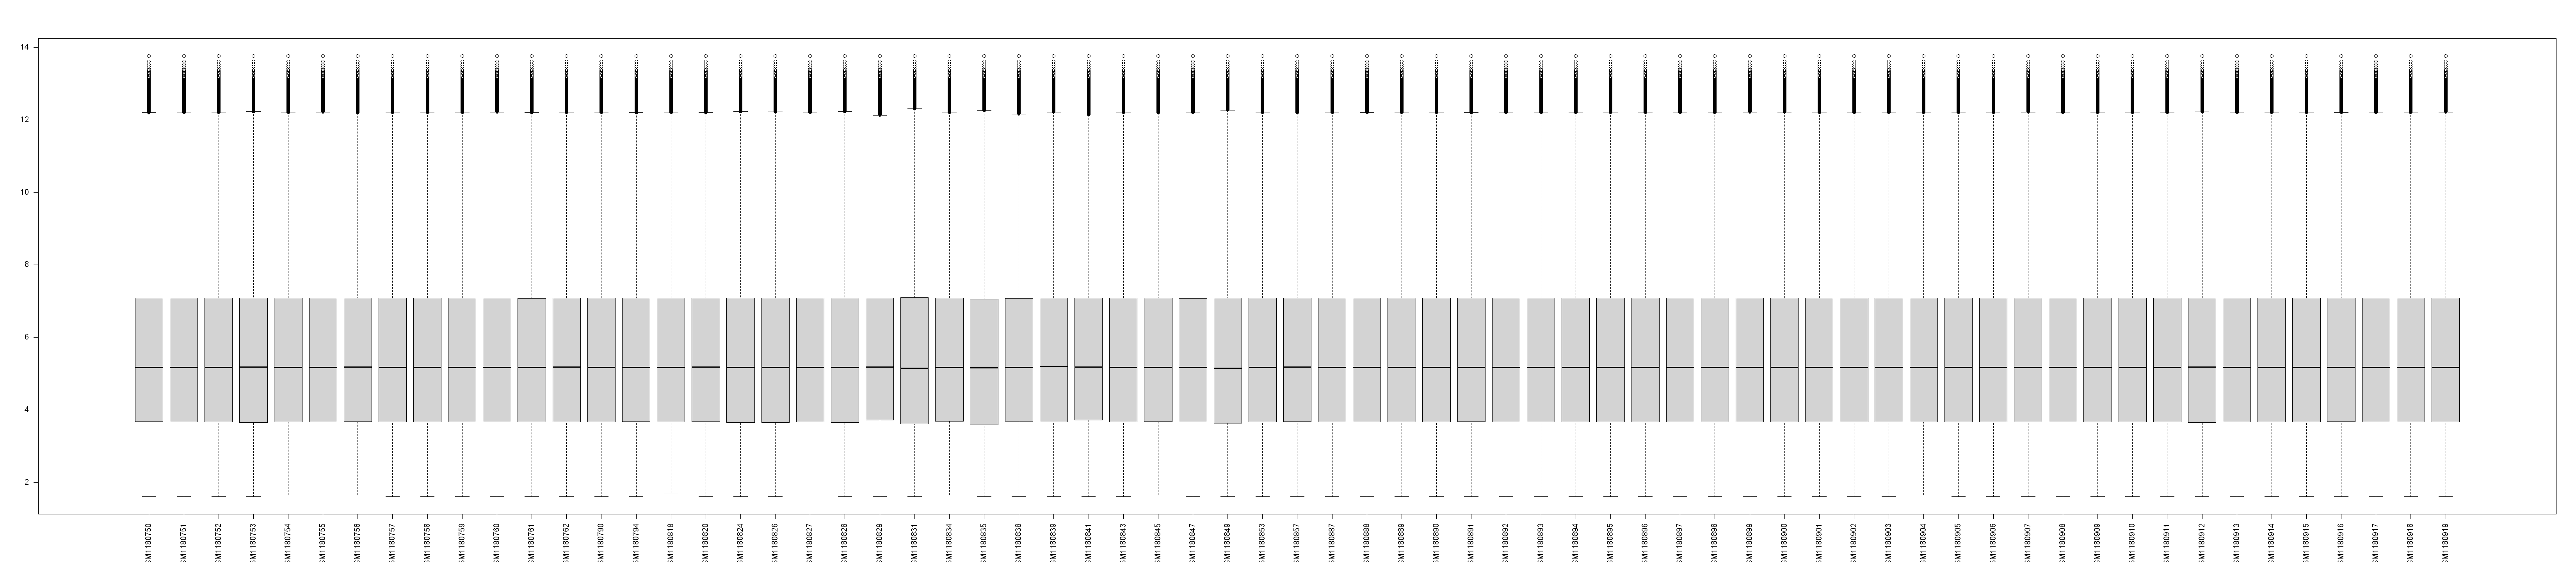

In [76]:
options(repr.plot.width=55, repr.plot.height=12)
boxplot(ex, las = 2)


As the plot represents, samples are well-scaled with approximately identical *5 number summary*[^1] values.

[^1]: minimum, lower-hinge, median, upper-hinge, maximum 

## Dimensionality Reduction
First, let's check our data dimensions again:

In [77]:
dim(gset)

Features  Samples 
   32321       67

___
As you see, we've got a $32321$-dimensional data, which is enormous! What we're about to do, is reduce the dimensions of our data while keeping as much variation in the original data as possible.  
   
but **How exactly is this *dimensionality reduction* going to help us?**   

1. Lower dimensionality means less computational resources, less training time, and more performance (because in a high-dimensional space, most data points are likely far from each other, and it's hard for the model to train effectivley on such data - ***curse of dimensionality***).  

2. When there are many features, the model tends to become more complex, resulting in overfitting. So the *dimensionality reduction* avoids the problem of **overfitting**.  

3. Imagine you want to **visualize** this $323321$-dimentional data! It's not that practical, is it?  
But when you reduce the dimensionality of higher dimension data to $2$ or $3$ components, it can easily be plotted on a $2D$ or $3D$ plot.  

4. **multicollinearity**  
It occurs when features are highly correlated with one or more of the other features in the dataset and affect the performance of regression and classification models. *Dimensionality reduction* takes advantage of multicollinearity and combines the highly correlated variables into a set of uncorrelated variables.  

5. When you keep the essential features and remove the others, the data **noise** is more likely to be removed, leading to higher model accuracy.   


You can see different methods of *dimensionality reduction* in the diagram below:

### Principal Component Analysis (PCA)
The first dimension reduction method that we're going to use is the *Principal Component Analysis (PCA)*. Principal component analysis is used to extract the important information from a multivariate data table and to express this information as a set of few new variables called principal components. PCA assumes that the directions with the largest variances are the most **important** while the amount of variance retained by each principal component is measured by the **eigenvalue**.   
We will use the `prcomp()` method to obtain the *PCA* and then plot it:

In [78]:
pc <- prcomp(ex)
get_eigenvalue(pc)[1:5, ]

,eigenvalue,variance.percent,cumulative.variance.percent
,<dbl>,<dbl>,<dbl>
Dim.1,299.598423,87.2509394,87.25094
Dim.2,12.643203,3.6820333,90.93297
Dim.3,6.430822,1.8728244,92.80580
Dim.4,5.144998,1.4983587,94.30416
Dim.5,3.140644,0.9146382,95.21879


As you can see, about $90.93%$ of the variance is retained by the first two *principal components*.  
Before going further, let's first plot the data according to $PC1$ and $PC2$:

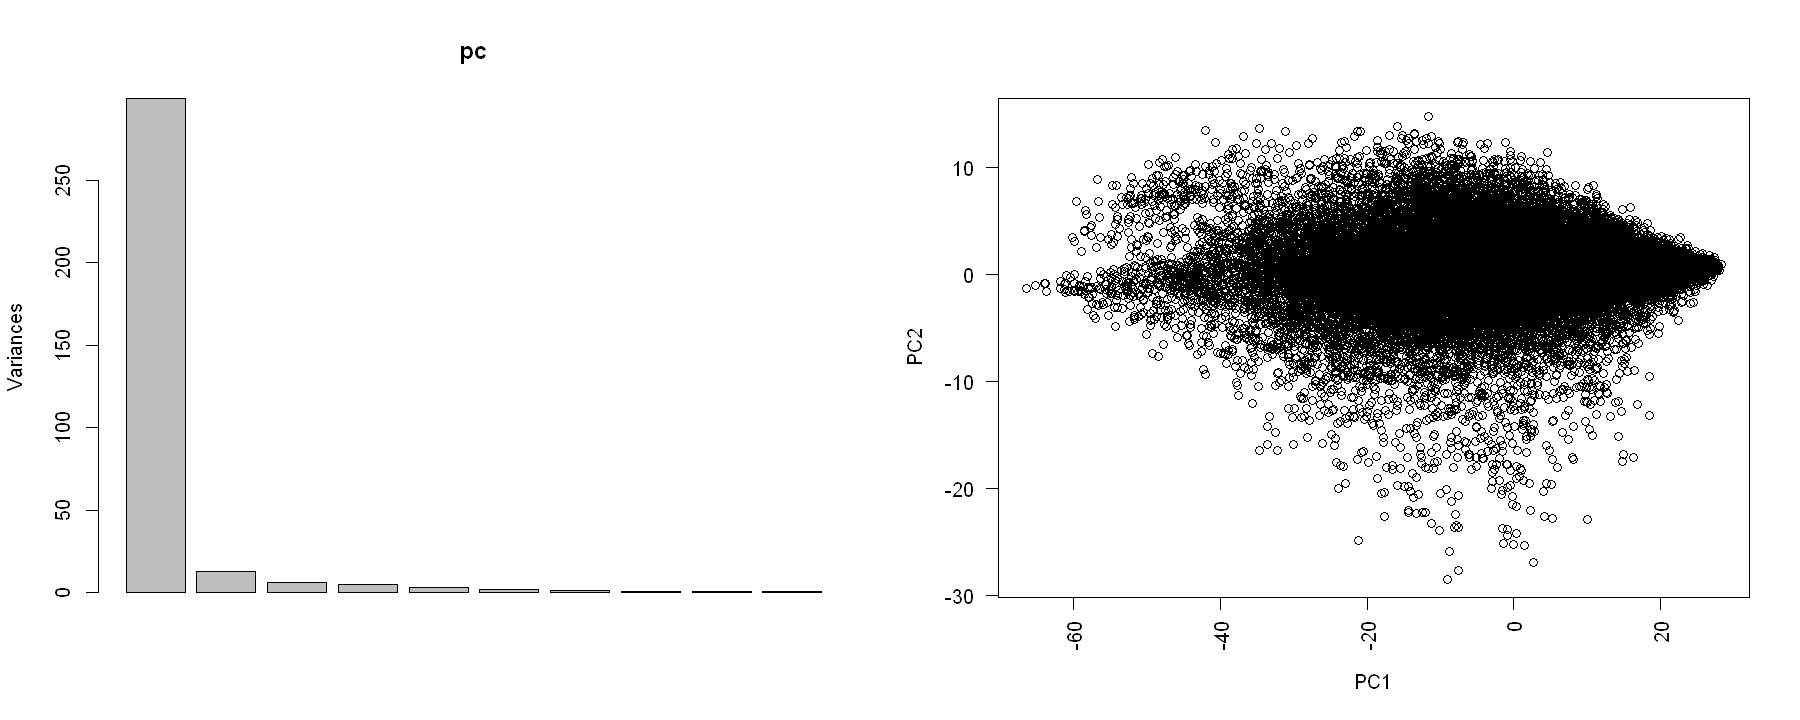

In [79]:
options(repr.plot.width=15, repr.plot.height=6)
par(mfrow = c(1, 2))
p1 <- plot(pc)
p2 <- plot(pc$x[, 1:2], las = 2)

The problem is, $PC1$ seems to present a misleading variance in the data points, acquired probably by the uninteresting expression differences between genes which often expressed (e.g. housekeeping genes) and those expressed rarely.

To overcome this problem, we are going to center[^1] our data columns using the `scale()` method:

[^1]: Subtracting columns mean from their corresponding columns.

In [80]:
ex.scale <- t(scale(t(ex), scale = F))
pc <- prcomp(ex.scale)
get_eigenvalue(pc)[1:5, ]

,eigenvalue,variance.percent,cumulative.variance.percent
,<dbl>,<dbl>,<dbl>
Dim.1,12.698222,28.876999,28.87700
Dim.2,6.434864,14.633510,43.51051
Dim.3,5.211775,11.852086,55.36259
Dim.4,3.142359,7.146032,62.50863
Dim.5,1.972313,4.485232,66.99386


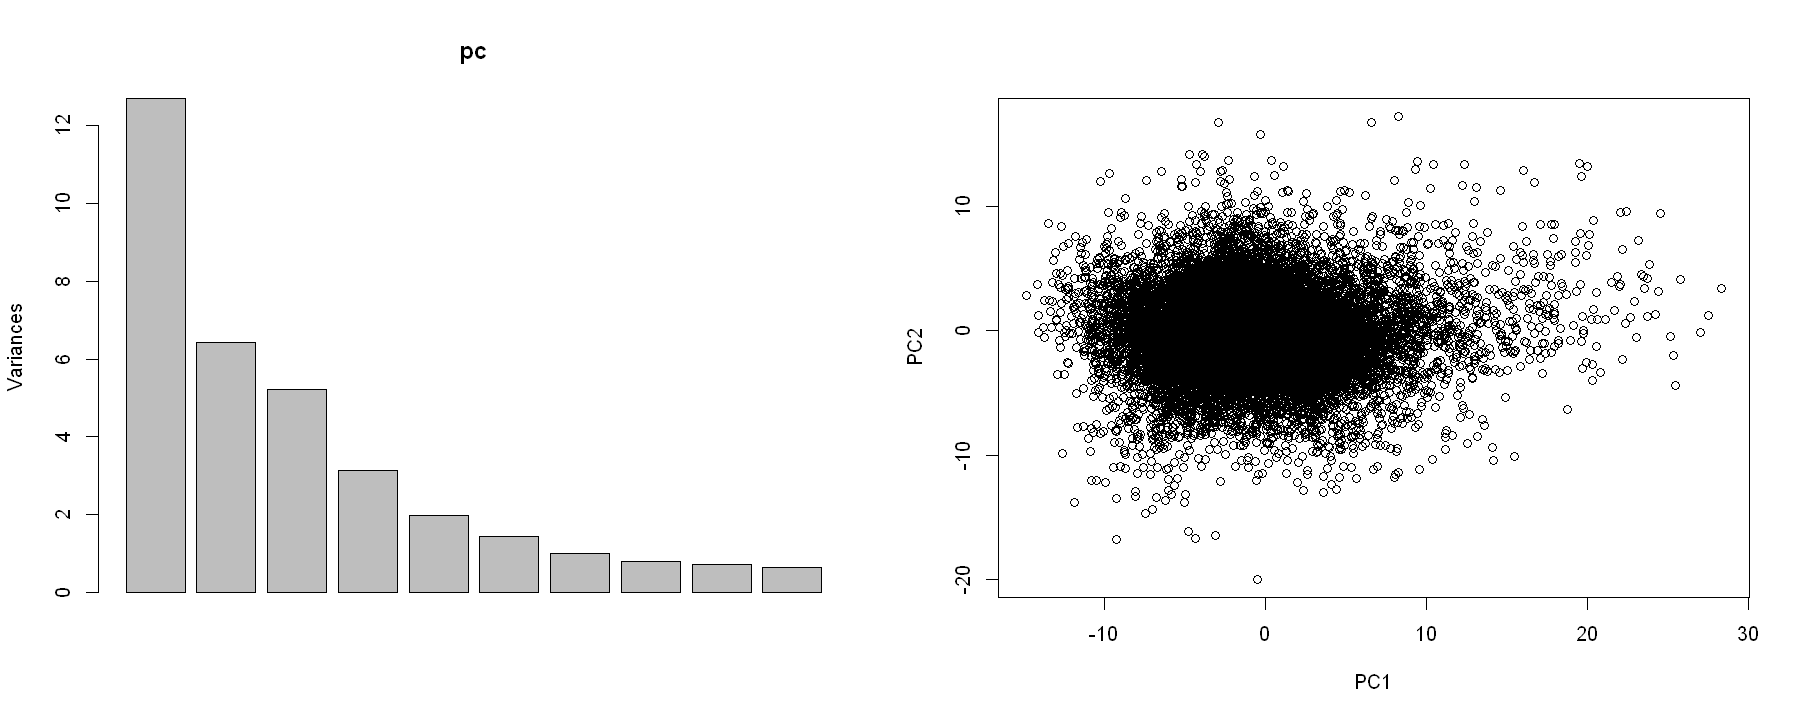

In [81]:
options(repr.plot.width=15, repr.plot.height=6)
par(mfrow = c(1, 2))
plot(pc)
plot(pc$x[, 1:2])

As you can see, now other components are contributing as well.

We can also plot the *PCA* results according to the *variables*(which are the samples in this case) instead of the *individuals*(which are the genes in this case) to demonstrate different sample groups and their correlation:

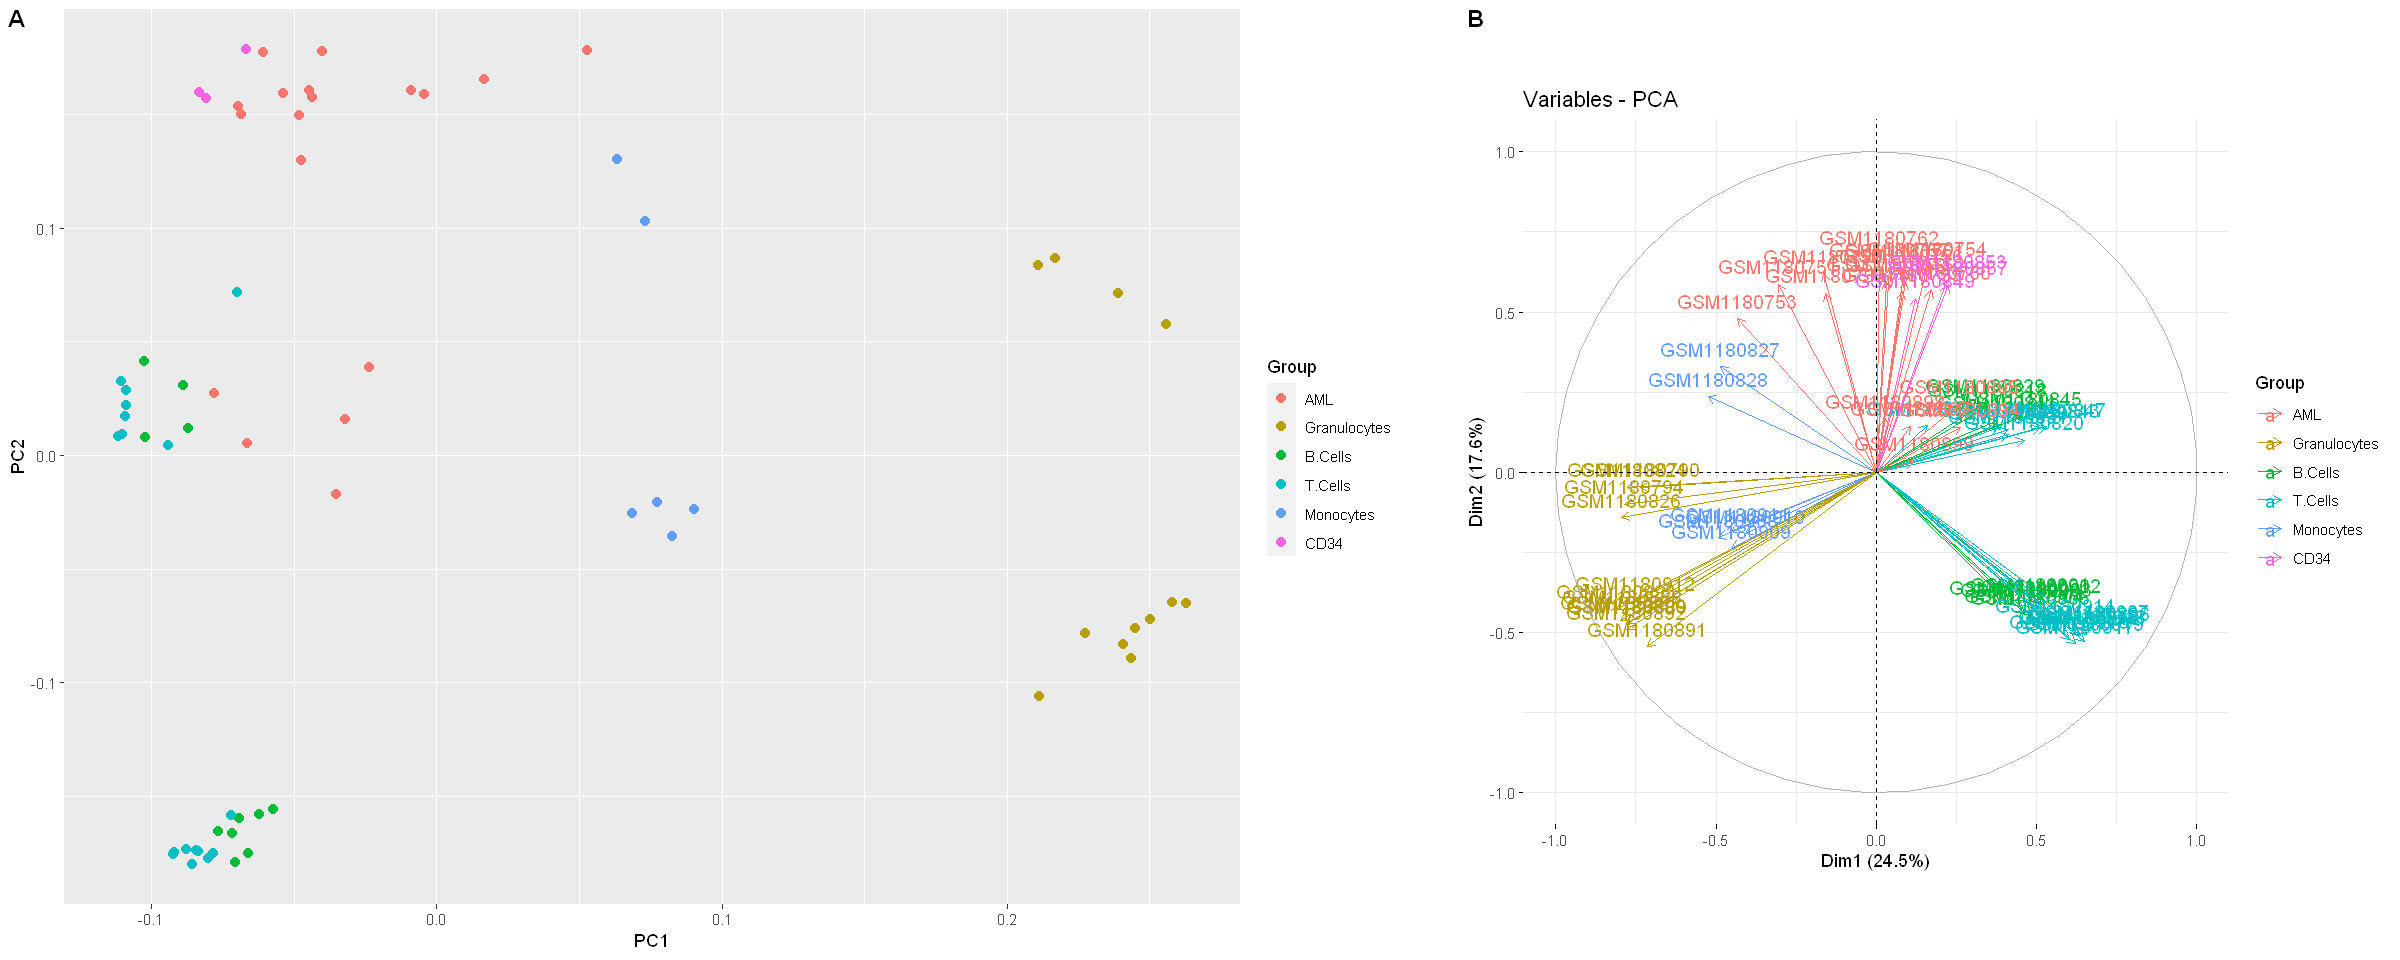

In [82]:
options(repr.plot.width=20, repr.plot.height=8)

pcr <- data.frame(pc$rotation[, 1:3], Group=gs)
pca.plot1 <- ggplot(pcr, 
                aes(x = PC1, 
                    y = PC2, 
                    color = Group)) + geom_point(size=2.5) + theme_gray()

pca.plot2 <- fviz_pca_var(PCA(ex.scale, graph = FALSE), 
                      col.var = gs,
                      legend.title = "Group")

ggarrange(pca.plot1, NULL, pca.plot2,
         widths = c(3, 0.1, 2),
         labels = c('A', '', 'B'),
         ncol = 3,
         nrow = 1)

About the figure *B*:

- Positively correlated variables are grouped together.
- Negatively correlated variables are positioned on opposite sides of the plot origin (opposed quadrants).

### t-distributed stochastic neighbor embedding (tSNE)
The next *dimension reduction* algorithm that we're going to try is the *tSNE* which as mentioned in [figure 1](#fig-1), is a **non-linear algorithm**. Non-linearity means that it's capable of separating data which can't be separated by a straight line, unlike the linear algorithms(e.g. *PCA*).  

We're going to use the `Rtsne()` method from the `Rtsne` package, to calculate the *tSNE* of our expression matrix. One parameter that we need to pass to the `Rtsne()` method is the **`perplexity`**. A perplexity is more or less a target number of neighbors for our central point. Basically, the higher the perplexity is, the higher the variance value.[^1]   

So we will calculate the *tSNE* for 3 `perplexity` values of $3, 5, 7, 10, 15$ and $20$. After plotting the result, we can choose the best value based on how well it separated the group clusters:

[^1]: https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a

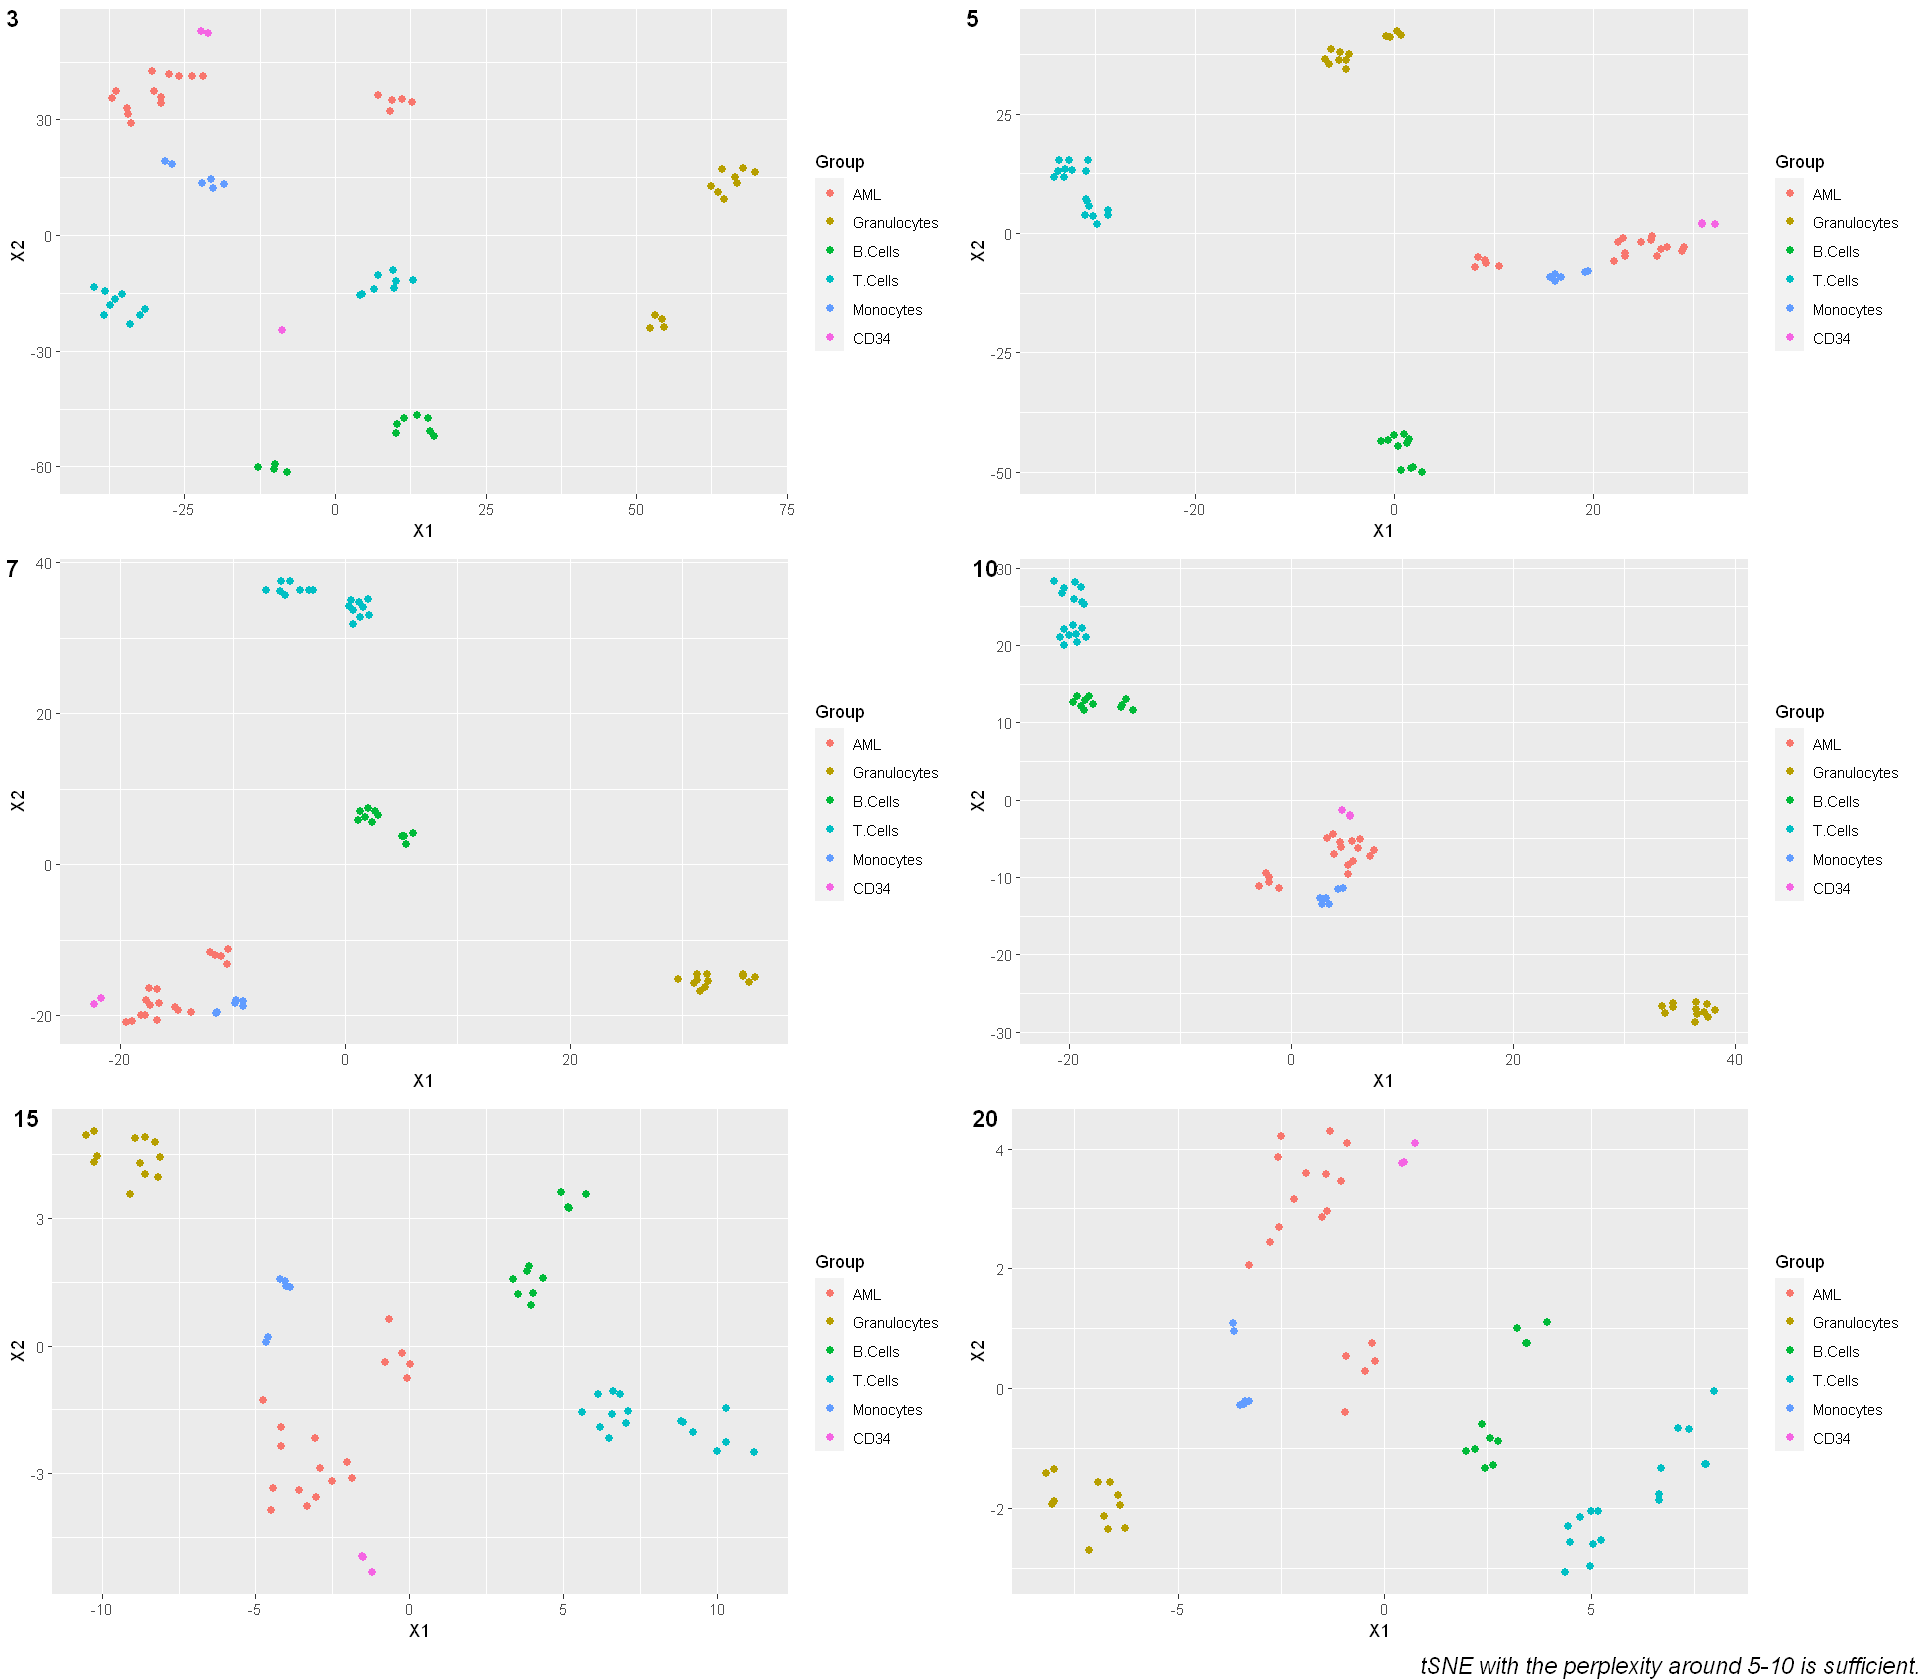

In [83]:
tsne_results <- list(Rtsne(t(ex), perplexity=3, check_duplicates = FALSE),
                     Rtsne(t(ex), perplexity=5, check_duplicates = FALSE),
                     Rtsne(t(ex), perplexity=7, check_duplicates = FALSE),
                     Rtsne(t(ex), perplexity=10, check_duplicates = FALSE),
                     Rtsne(t(ex), perplexity=15, check_duplicates = FALSE),
                     Rtsne(t(ex), perplexity=20, check_duplicates = FALSE))

options(repr.plot.width=16, repr.plot.height=14)
tsne.plots.list <- list()

for(i in seq_along(tsne_results)) {
  tsne <- data.frame(tsne_results[[i]]$Y[, 1:2], Group=gs)
  tsne.plots.list[[i]] <- ggplot(tsne, aes(X1, X2, color = Group)) + geom_point(size=2) + theme_gray()
}
ggarr <- ggarrange(plotlist = tsne.plots.list, 
                   ncol = 2, 
                   nrow = 3,
                  labels = c(3, 5, 7, 10, 15, 20))
annotate_figure(ggarr,
               bottom = text_grob("tSNE with the perplexity around 5-10 is sufficient.",
                                  hjust = 1,
                                  x = 1,
                                  face = "italic",
                                  size = 14)
               )


According to the plots, *tSNE* with the `perplexity` in a range $[5, 10]$ was almost successful to separate different groups of samples **except for the *AML*, *CD34+*, and *Monocytes*** which brings this idea to mind that expressions in these groups were highly similar/correlated.

### Multidimensional scaling (MDS)
*MDS* returns an optimal solution to represent the data in a lower-dimensional space, where the number of dimensions $k$ is pre-specified by the analyst. For example, choosing $k = 2$ optimizes the object locations for a two-dimensional scatter plot.  

The input data for MDS is a dissimilarity matrix representing the distances between pairs of objects. So first we will compute the distance matrix using the `dist()` method:

In [84]:
ex_dist <- dist(t(ex.scale))

Now we can pass the `ex_dist` to the `cmdscale` from the `stats` package to compute the *mds* result:

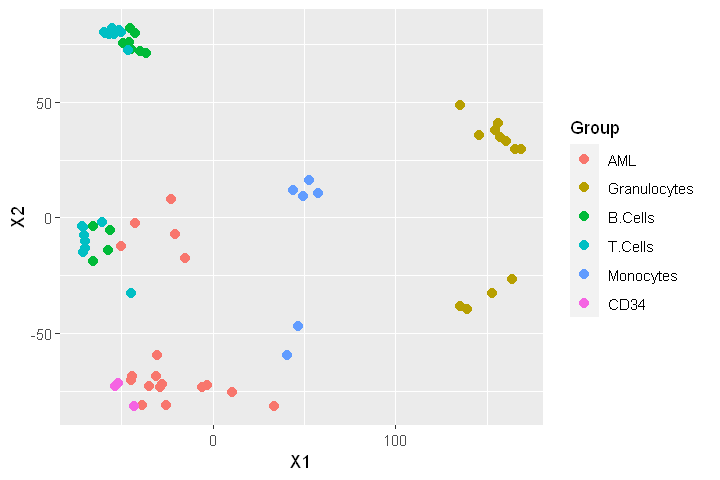

In [85]:
options(repr.plot.width=6, repr.plot.height=4)

mds_result <- cmdscale(ex_dist, eig=TRUE, k=2)
mds_df <- data.frame(mds_result$points[,1:2], Group=gs)
mds.plot <- ggplot(mds_df, aes(X1,X2, color = Group)) + geom_point(size=2.5) + theme_gray()
mds.plot

### PCA vs. tSNE vs. MDS
To compare the results of these 3 methods, we will plot their results one more time to make it easier for comparing:

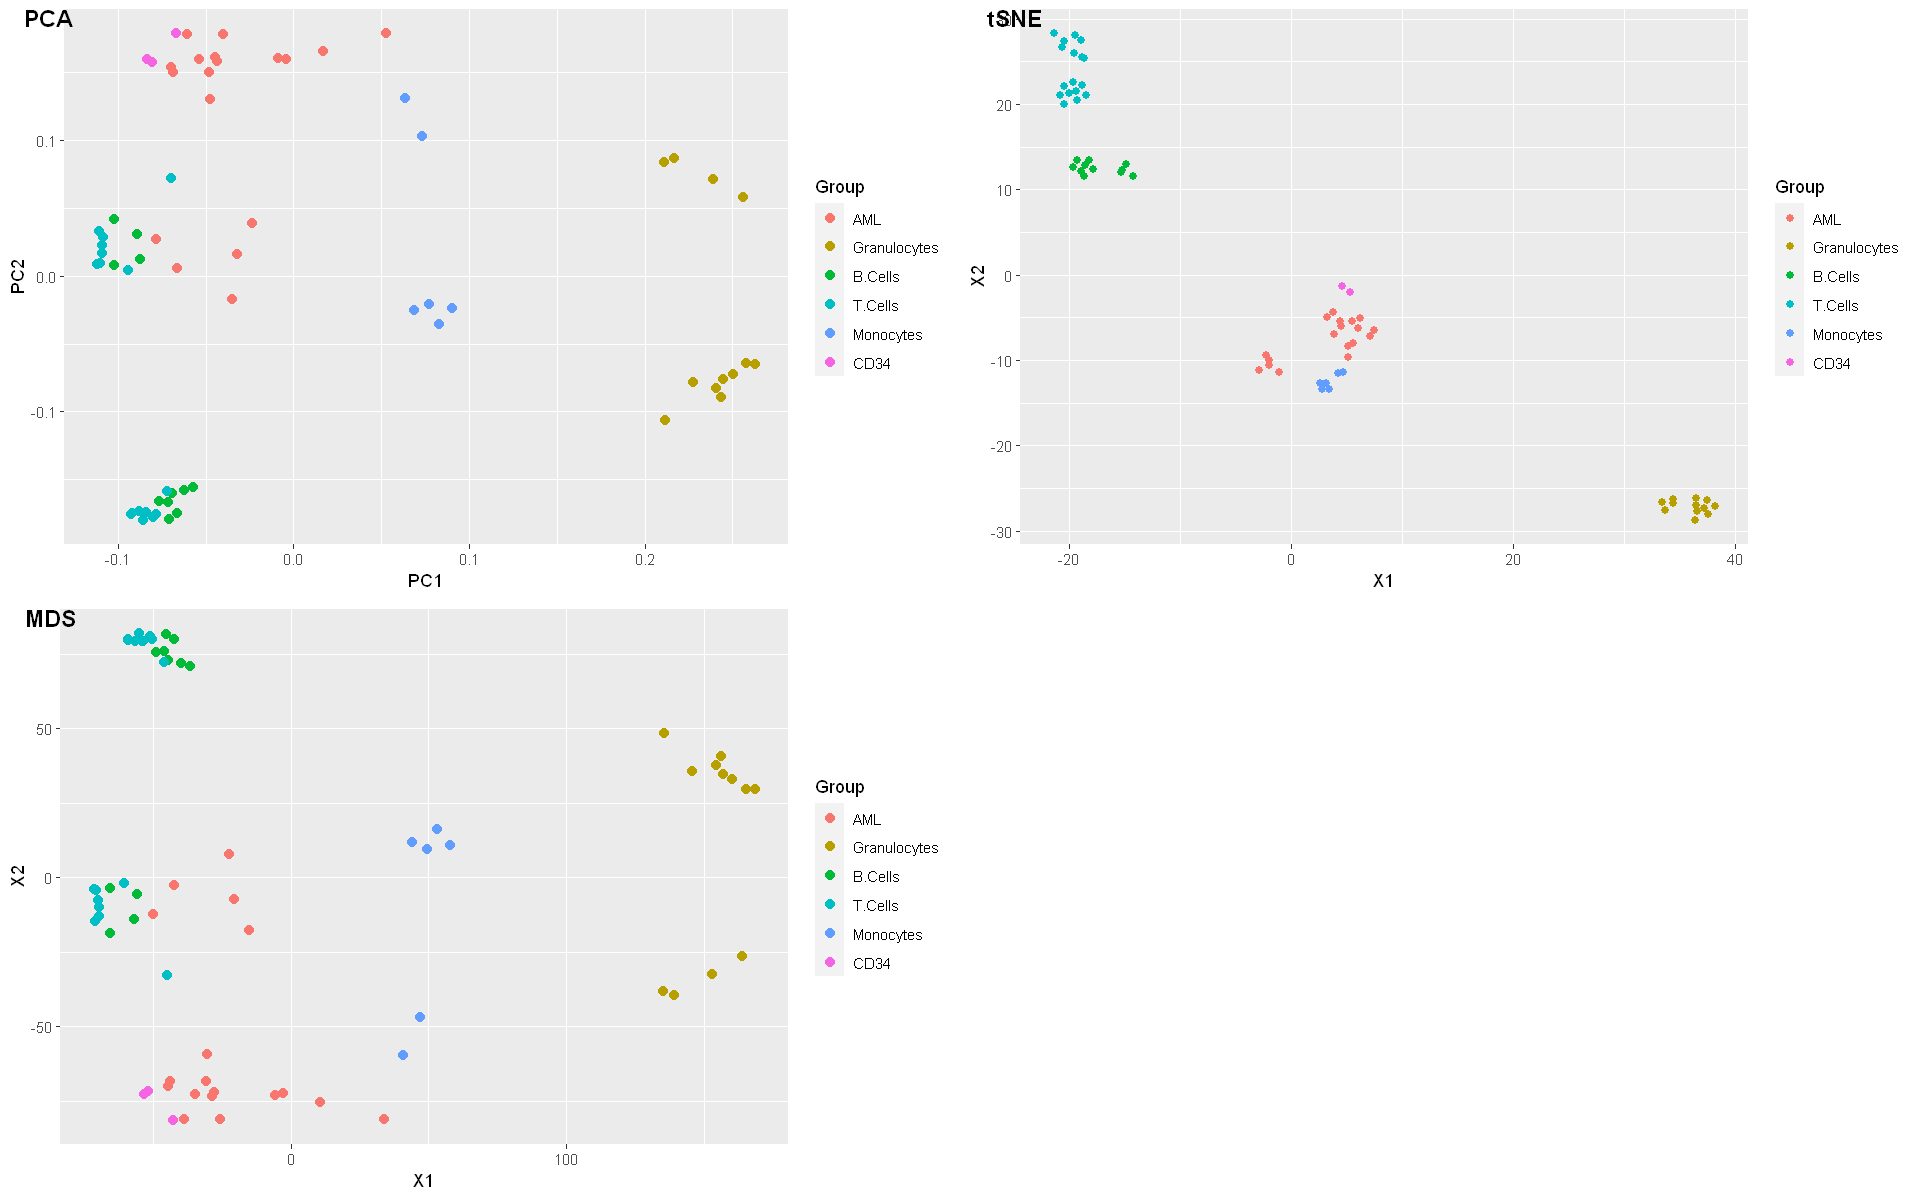

In [86]:
options(repr.plot.width=16, repr.plot.height=10)
ggarrange(pca.plot1, tsne.plots.list[[4]], mds.plot,
          ncol = 2,
          nrow = 2,
          labels = c('PCA', 'tSNE', 'MDS'))

According to plots, we believe that the ***tSNE*** was able to separate groups of samples more precisely.

## Correlation between samples
Heat map shows correlations between different samples. For example each group has high corealation with itself that is determined by red color or *Granulocytes* have a low correlation with *B-cells* and *T-cells* which is determined by blue color.

According to the heatmap, ***AML*** has a high correlation with ***CD34+*** and ***Monocytes*** which makes these 2 groups, proper candidates to check whether there are any significant expression differences between their genes and the *AML* ones.

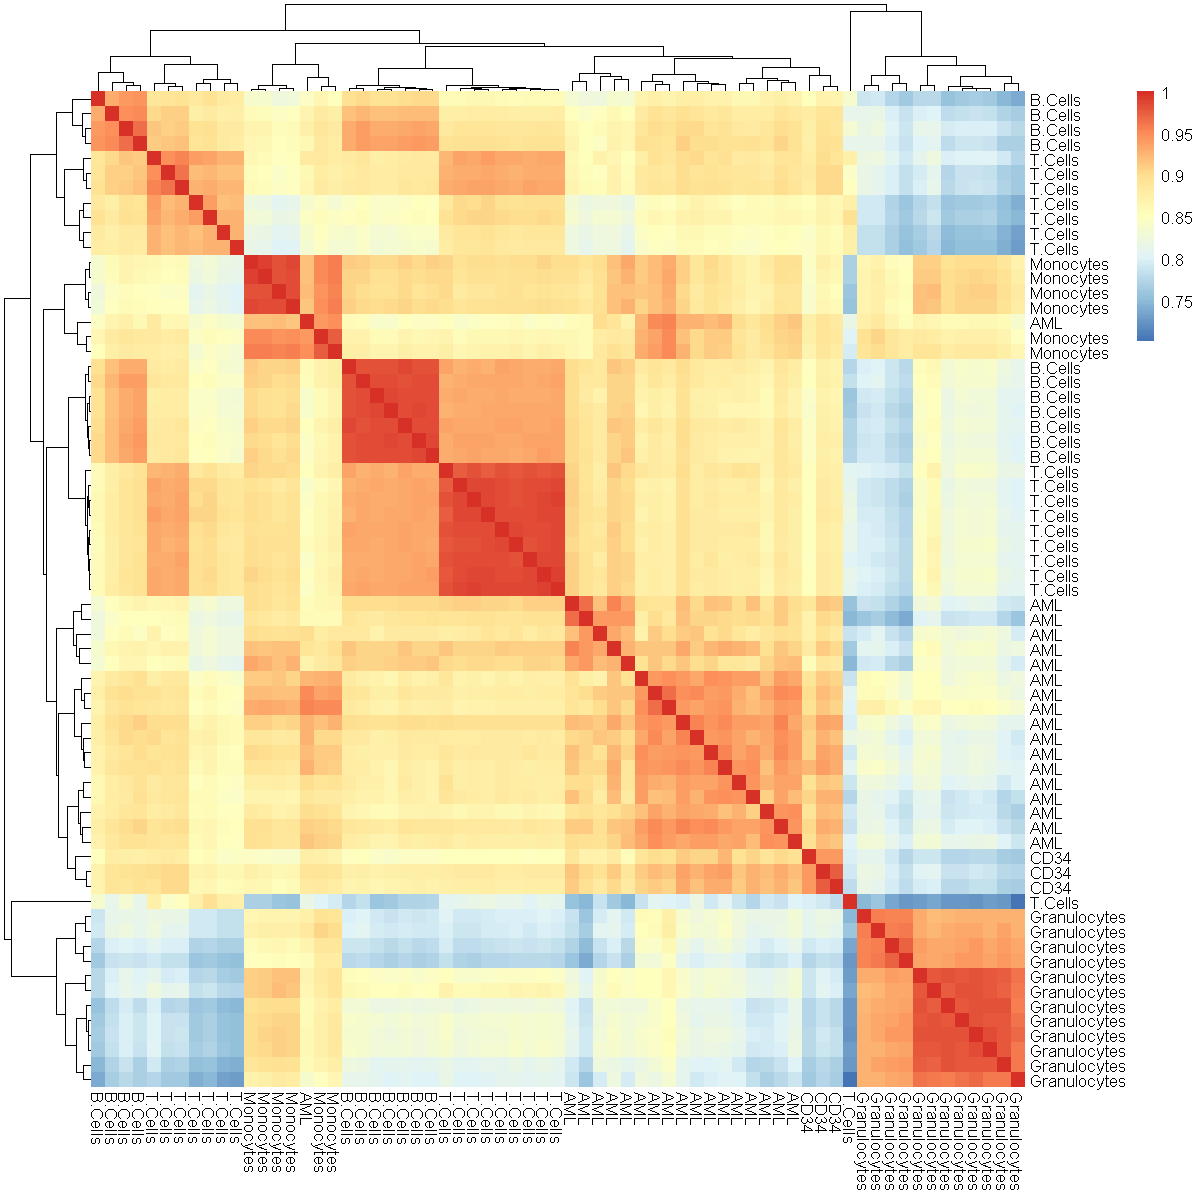

In [87]:
options(repr.plot.width=10, repr.plot.height=10)
pheatmap(cor(ex),
         labels_row = gs,
         labels_col = gs,
         border_color = NA,)

calculate dif matrix


In [90]:
gs <- factor(gs)
gset$description <- gs
design <- model.matrix(~ description + 0 , gset)
colnames(design) <- levels(gs)
fit <- lmFit(gset,design)
cont.matrix <- makeContrasts(AML-CD34,levels = design)
fit2 <- contrasts.fit(fit,cont.matrix)
fit2 <- eBayes(fit2,0.01)
tT <- topTable(fit2,adjust="fdr",sort.by = "B",number = Inf)
tT <- subset(tT,select=c("Gene.symbol","Gene.ID","adj.P.Val","logFC"))
write.table(tT,file = "../Results/AML_CD34.txt",row.names = F,sep = "\t",quote = F)

[1] "ID"                    "Gene.title"            "Gene.symbol"          
 [4] "Gene.ID"               "UniGene.title"         "UniGene.symbol"       
 [7] "UniGene.ID"            "Nucleotide.Title"      "GI"                   
[10] "GenBank.Accession"     "Platform_CLONEID"      "Platform_ORF"         
[13] "Platform_SPOTID"       "Chromosome.location"   "Chromosome.annotation"
[16] "GO.Function"           "GO.Process"            "GO.Component"         
[19] "GO.Function.ID"        "GO.Process.ID"         "GO.Component.ID"      
[22] "logFC"                 "AveExpr"               "t"                    
[25] "P.Value"               "adj.P.Val"             "B"

calculate up gene

In [61]:
aml.up <- subset(tT,logFC > 1 & adj.P.Val <0.05)
aml.up.genes <- unique(aml.up$ID)
write.table(aml.up.genes , file = "../Results/AML_CD34_Up.txt",quote = F,col.names = F,row.names = F)

calculate down gene

In [62]:
aml.down <- subset(tT,logFC < -1 & adj.P.Val <0.05)
aml.down.genes <- unique(aml.down$ID)
write.table(aml.down.genes , file = "../Results/AML_CD34_Down.txt",quote = F,col.names = F,row.names = F)


# References

- [https://maktabkhooneh.org - Advanced Bioinformatics course](https://maktabkhooneh.org/course/%D8%A8%DB%8C%D9%88%D8%A7%D9%86%D9%81%D9%88%D8%B1%D9%85%D8%A7%D8%AA%DB%8C%DA%A9-%D9%BE%DB%8C%D8%B4%D8%B1%D9%81%D8%AA%D9%87-mk375/#seasons)
- [https://www.nature.com - microarray](https://www.nature.com/scitable/definition/microarray-202/)
- [https://www.digitalocean.com - How to Normalize data in R](https://www.digitalocean.com/community/tutorials/normalize-data-in-r)
- [https://www.v7labs.com - A Simple Guide to Data Preprocessing in Machine Learning](https://www.v7labs.com/blog/data-preprocessing-guide)
- [https://machinelearningmastery.com - Introduction to Dimensionality Reduction for Machine Learning](https://machinelearningmastery.com/dimensionality-reduction-for-machine-learning/)
- [https://towardsdatascience.com - 11 Dimensionality reduction techniques you should know in 2021](https://towardsdatascience.com/11-dimensionality-reduction-techniques-you-should-know-in-2021-dcb9500d388b)
- [http://www.sthda.com - Principal Component Analysis in R: prcomp vs princomp](http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/118-principal-component-analysis-in-r-prcomp-vs-princomp/)
- [http://www.sthda.com - Principal Component Analysis Essentials](http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/112-pca-principal-component-analysis-essentials/)
- [https://ajitjohnson.com - Getting started with t-SNE for biologist (R)](https://ajitjohnson.com/tsne-for-biologist-tutorial/)
- [https://towardsdatascience.com - t-SNE clearly explained](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)
- [http://www.sthda.com - Multidimensional Scaling Essentials: Algorithms and R Code](http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/122-multidimensional-scaling-essentials-algorithms-and-r-code/)

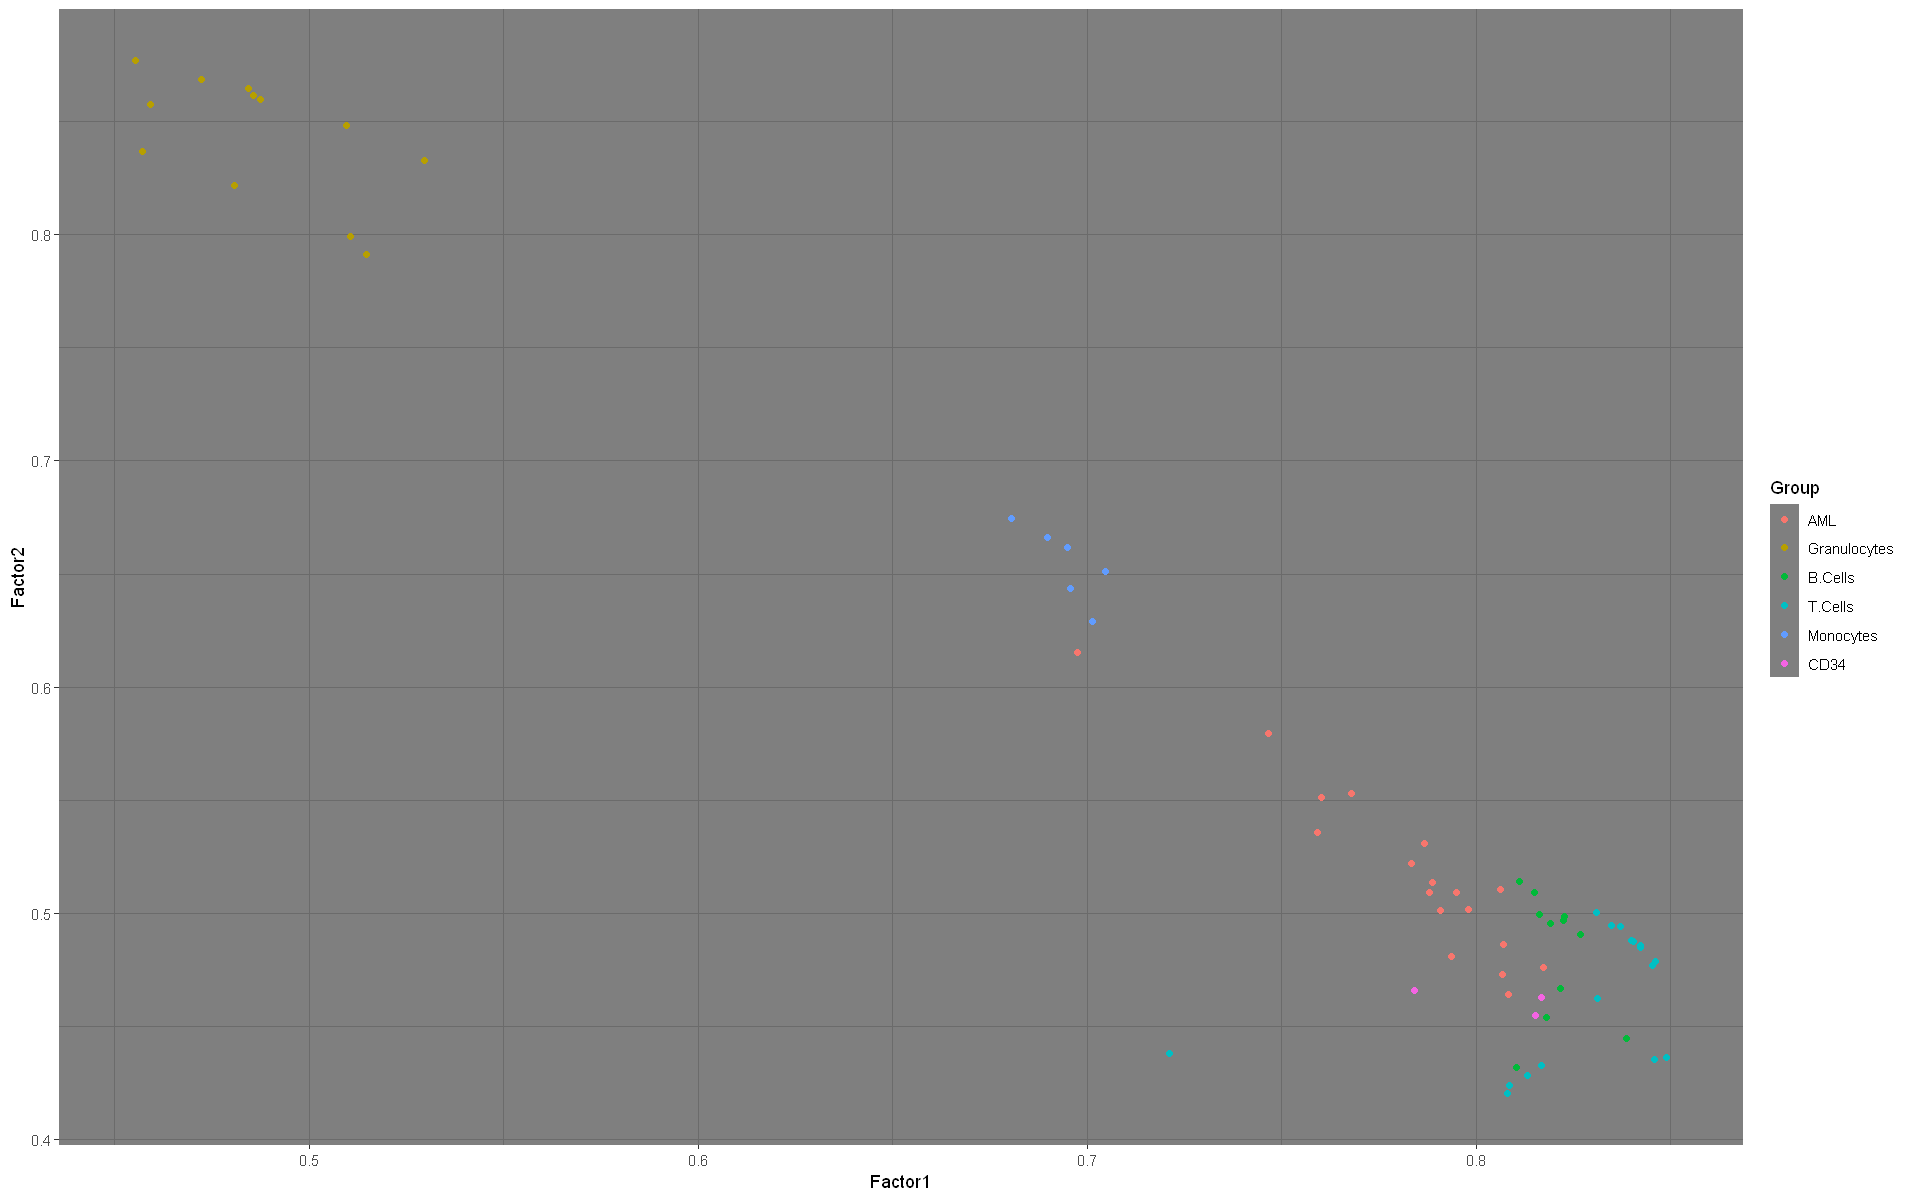

In [26]:
fa_result <- factanal(ex, factors = 2)
fa_df <- data.frame(fa_result$loadings[,1:2], Group=gs)
ggplot(fa_df, aes(Factor1,Factor2, color = Group)) + geom_point() + theme_dark()

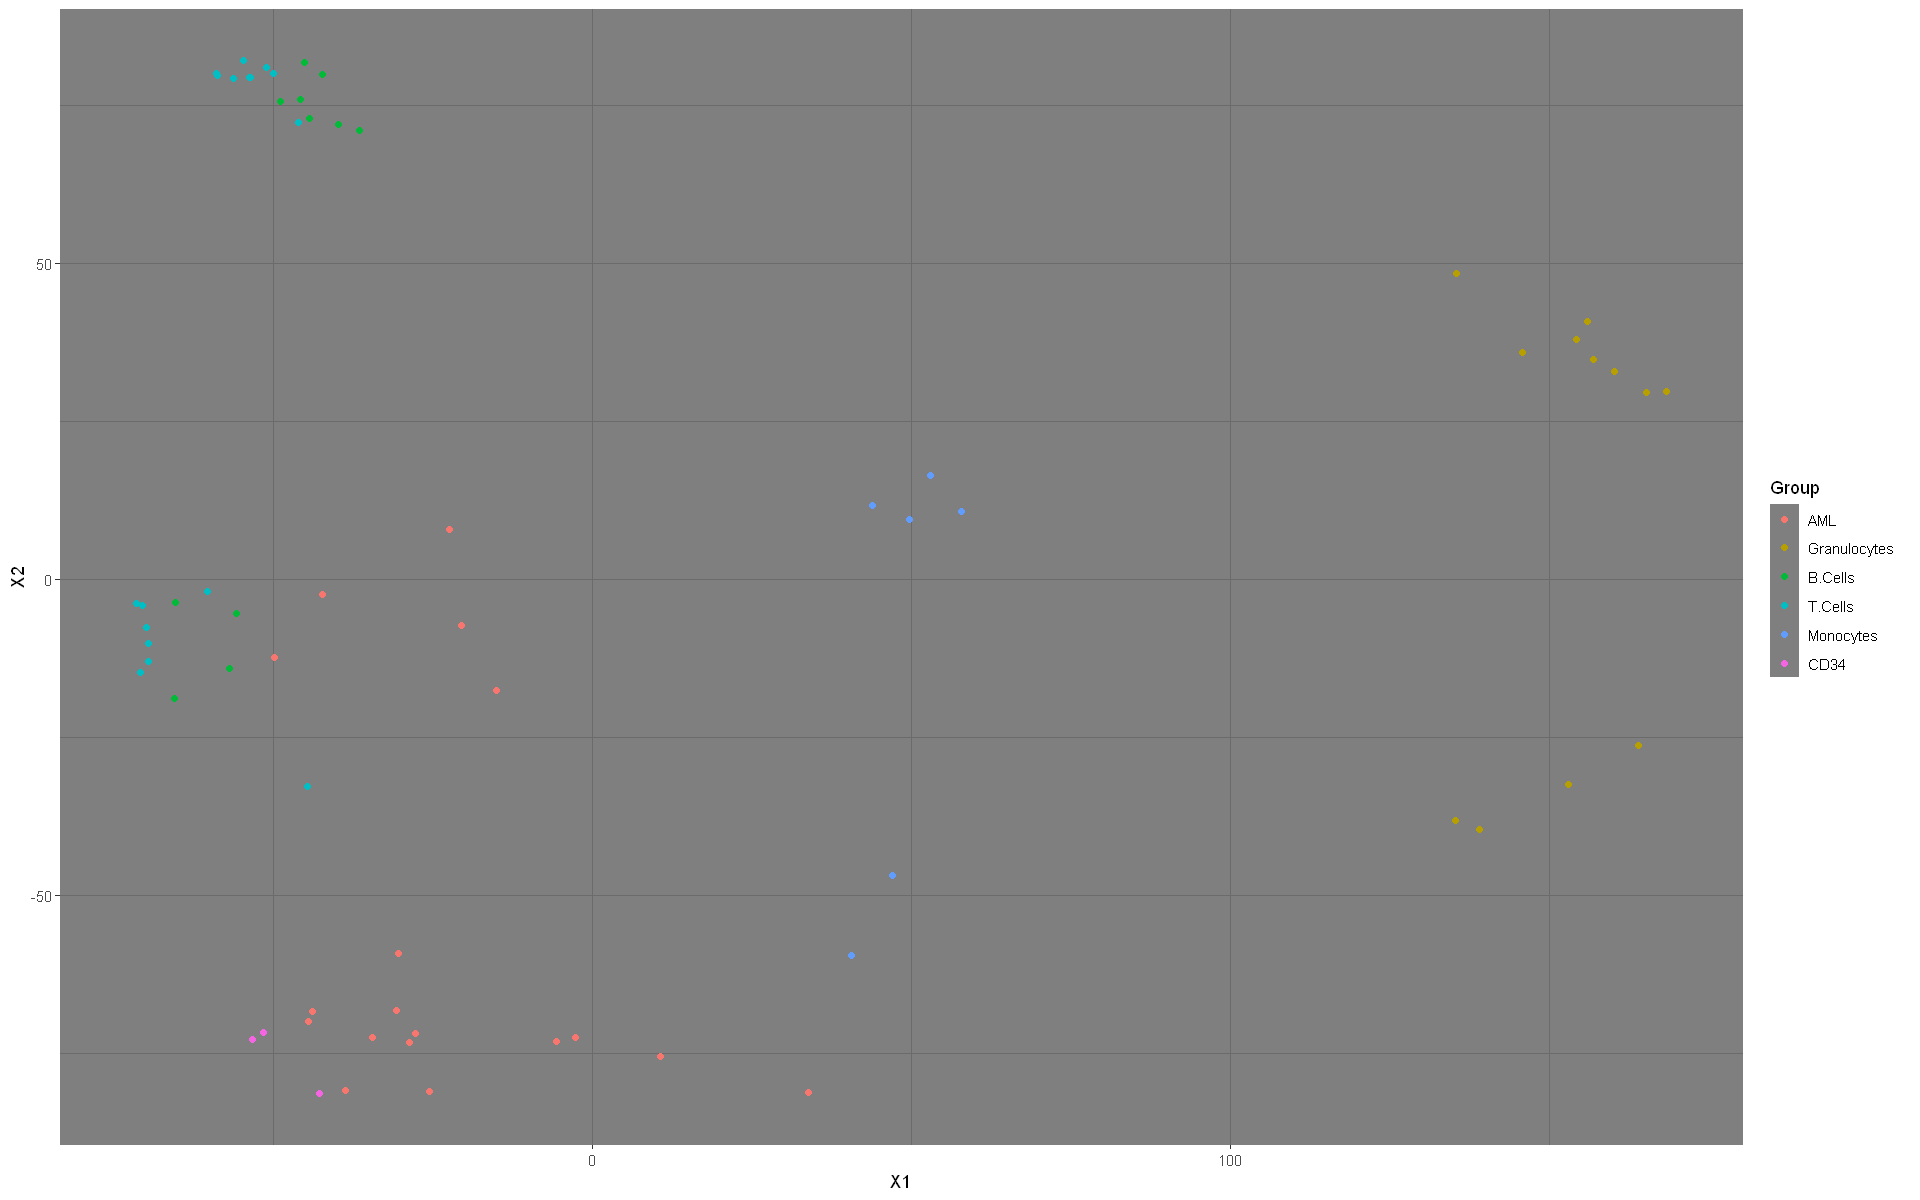

In [25]:
ex_dist <- dist(t(ex.scale))
mds_result <- cmdscale(ex_dist,eig=TRUE, k=2)
mds_df <- data.frame(mds_result$points[,1:2], Group=gs)
ggplot(mds_df, aes(X1,X2, color = Group)) + geom_point() + theme_dark()